In [1]:
import tensorflow as tf
import time
from datetime import timedelta
import numpy as np
ks=tf.keras
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Data

In [2]:
from kgcnn.graph.base import GraphDict
from kgcnn.data.base import MemoryGraphList, MemoryGraphDataset
from kgcnn.data.qm import QMDataset

In [3]:
dataset = QMDataset(data_directory="ExampleQM", file_name="ThiolDisulfidExchange.csv", dataset_name="ThiolDisulfidExchange")

In [4]:
dataset.prepare_data(overwrite=True, make_sdf = True);

INFO:kgcnn.data.ThiolDisulfidExchange:Converting xyz to mol information.


In [5]:
dataset.read_in_memory(label_column_name="energy");

INFO:kgcnn.data.ThiolDisulfidExchange:Reading structures from SDF file.
INFO:kgcnn.data.ThiolDisulfidExchange: ... process molecules 0 from 5112
INFO:kgcnn.data.ThiolDisulfidExchange: ... process molecules 5000 from 5112


In [6]:
dataset.map_list(method="set_range", max_distance=5.0);
dataset.map_list(method="set_angle");

In [7]:
dataset.save();

INFO:kgcnn.data.ThiolDisulfidExchange:Pickle dataset...


In [3]:
dataset = MemoryGraphDataset(data_directory="ExampleQM", dataset_name="ThiolDisulfidExchange")
dataset.load();
dataset[0].keys()

INFO:kgcnn.data.ThiolDisulfidExchange:Load pickled dataset...


dict_keys(['node_symbol', 'node_number', 'node_coordinates', 'edge_indices', 'edge_number', 'graph_labels', 'range_indices', 'range_attributes', 'angle_indices', 'angle_indices_nodes', 'angle_attributes', 'rep'])

## 2. Model

In [4]:
from kgcnn.literature.HDNNP2nd import make_model

In [5]:
model_config = {
    "name": "HDNNP2nd",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True}],
    "w_acsf_ang_kwargs": {"eta": [0.0, 0.3], "rs": [0.0, 3.0], "rc": 10.0, "elements": [1, 6, 16]},
    "w_acsf_rad_kwargs": {"eta": [0.0, 0.3], "lamda": [-1.0, 1.0], "rc": 6.0,
                  "zeta": [1.0, 8.0], "elements": [1, 6, 16], "multiplicity": 2.0},
    "mlp_kwargs": {"units": [35, 1],
                   "num_relations": 17,
                   "activation": ["swish", "linear"]},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["swish", "linear"]}
}

In [6]:
model = make_model(**model_config);

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'normalize_kwargs': None, 'mlp_kwargs': {'units': [35, 1], 'num_relations': 17, 'activation': ['swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being ca

In [7]:
inputs = dataset.tensor(model_config["inputs"])
len(inputs), inputs[0].shape, inputs[1].shape, inputs[2].shape, inputs[3].shape

(4,
 TensorShape([5112, None]),
 TensorShape([5112, None, 3]),
 TensorShape([5112, None, 2]),
 TensorShape([5112, None, 3]))

In [8]:
from kgcnn.scaler.mol import ExtensiveMolecularScaler
scaler = ExtensiveMolecularScaler(standardize_scale=False)
labels = np.expand_dims(np.array(dataset.get("graph_labels"))/0.0367493, axis=-1)

In [9]:
labels = scaler.fit_transform(labels, atomic_number=dataset.get("node_number"))
labels.shape

(5112, 1)

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits= 2, random_state=42, shuffle=True)

In [13]:
for train_index, test_index in kf.split(X=labels):
    print(len(train_index))
    model = make_model(**model_config)
    model.compile(loss="mean_absolute_error", metrics=["mean_absolute_error"], 
                  optimizer=ks.optimizers.Adam(learning_rate=5e-5))
    
    x_train, y_train = dataset[train_index].tensor(model_config["inputs"]), labels[train_index]
    x_test, y_test = dataset[test_index].tensor(model_config["inputs"]), labels[test_index]
    
    start = time.process_time()
    hist = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=5,
    )
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))

model.summary()

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'normalize_kwargs': None, 'mlp_kwargs': {'units': [35, 1], 'num_relations': 17, 'activation': ['swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}


2556


c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/5
80/80 [==============================] - 13s 115ms/step - loss: 44.4139 - mean_absolute_error: 44.4139 - val_loss: 28.0452 - val_mean_absolute_error: 28.0452
Epoch 2/5
80/80 [==============================] - 6s 70ms/step - loss: 22.8779 - mean_absolute_error: 22.8779 - val_loss: 18.2267 - val_mean_absolute_error: 18.2267
Epoch 3/5
80/80 [==============================] - 6s 72ms/step - loss: 14.2638 - mean_absolute_error: 14.2638 - val_loss: 11.5207 - val_mean_absolute_error: 11.5207
Epoch 4/5
80/80 [==============================] - 6s 72ms/step - loss: 9.0822 - mean_absolute_error: 9.0822 - val_loss: 6.9527 - val_mean_absolute_error: 6.9527
Epoch 5/5
80/80 [==============================] - 5s 68ms/step - loss: 5.2891 - mean_absolute_error: 5.2891 - val_loss: 4.2091 - val_mean_absolute_error: 4.2091


INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP2nd', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}], 'w_acsf_ang_kwargs': {}, 'w_acsf_rad_kwargs': {}, 'normalize_kwargs': None, 'mlp_kwargs': {'units': [35, 1], 'num_relations': 17, 'activation': ['swish', 'linear']}, 'node_pooling_args': {'pooling_method': 'sum'}, 'verbose': 10, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_output_mlp': False, 'output_mlp': {'use_bias': [True, True], 'units': [64, 1], 'activation': ['swish', 'linear']}}


Print Time for training:  0:00:33.375000
2556
Epoch 1/5
80/80 [==============================] - 10s 85ms/step - loss: 1092.8093 - mean_absolute_error: 1092.8093 - val_loss: 970.8084 - val_mean_absolute_error: 970.8084
Epoch 2/5
80/80 [==============================] - 5s 66ms/step - loss: 857.0148 - mean_absolute_error: 857.0148 - val_loss: 735.7560 - val_mean_absolute_error: 735.7560
Epoch 3/5
80/80 [==============================] - 5s 64ms/step - loss: 621.0488 - mean_absolute_error: 621.0488 - val_loss: 500.1929 - val_mean_absolute_error: 500.1929
Epoch 4/5
80/80 [==============================] - 5s 64ms/step - loss: 384.7197 - mean_absolute_error: 384.7197 - val_loss: 263.8023 - val_mean_absolute_error: 263.8023
Epoch 5/5
80/80 [==============================] - 5s 64ms/step - loss: 146.2922 - mean_absolute_error: 146.2922 - val_loss: 24.9735 - val_mean_absolute_error: 24.9735
Print Time for training:  0:00:33.156250
Model: "HDNNP2nd"
____________________________________________

In [15]:
true_y = scaler.inverse_transform(labels[test_index], atomic_number=dataset[test_index].get("node_number"))
start = time.process_time()
predicted_y = scaler.inverse_transform(model.predict(x_test), atomic_number=dataset[test_index].get("node_number"))
stop = time.process_time()
print("Print Time for training: ", str(timedelta(seconds=stop - start)))

80/80 [==============================] - 4s 51ms/step
Print Time for training:  0:00:04.328125


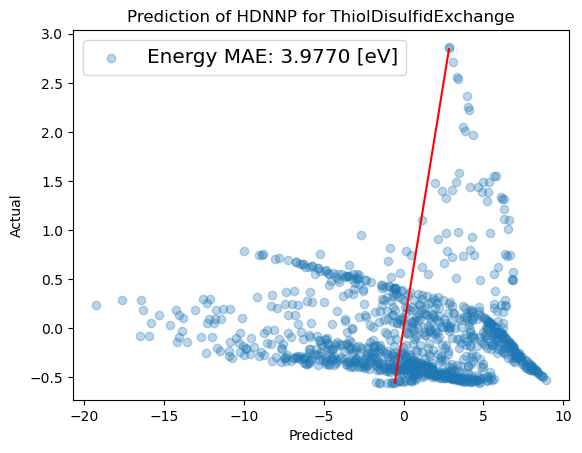

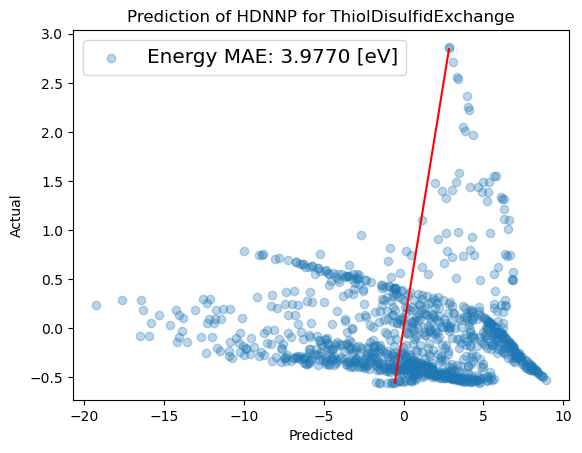

In [14]:
from kgcnn.utils.plots import plot_predict_true
plot_predict_true(predicted_y, true_y,
                  filepath="ExampleQM/", data_unit="eV",
                  model_name="HDNNP", dataset_name="ThiolDisulfidExchange", target_names="Energy",
                  file_name=f"predict.png")

In [24]:
predicted_y.shape

(1022, 1)